In [10]:
import time
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import gymnasium
import highway_env
from stable_baselines3 import DQN
%matplotlib inline

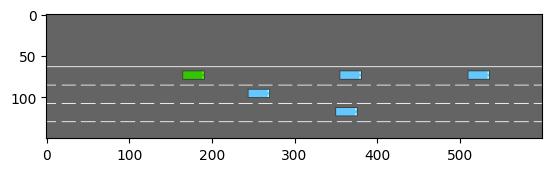

In [15]:
env = gymnasium.make('highway-v0', render_mode='rgb_array')
env.reset()
for _ in range(3):
    action = env.unwrapped.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
plt.show()
time.sleep(3)
env.close()

In [12]:
env = gymnasium.make("highway-fast-v0",render_mode='rgb_array', config={
      "simulation_frequency": 50,
      })
model = DQN('MlpPolicy', env,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="highway_dqn/")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [13]:
print("Entering training...")
model.learn(int(2e4))
model.save("highway_dqn/model_bh_drive")
print("Training completed.")

Entering training...
Logging to highway_dqn/DQN_14


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.25     |
|    ep_rew_mean      | 5.97     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 5        |
|    total_timesteps  | 33       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 7.37     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 13       |
|    total_timesteps  | 80       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.67     |
|    ep_rew_mean      | 7.13     |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes       

In [14]:
# Load and test saved model
model = DQN.load("highway_dqn/model_bh_drive0")
while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

AttributeError: 'NoneType' object has no attribute 'get_image'

In [24]:
import gymnasium
from stable_baselines3 import DQN
import numpy as np

class TargetedAggressiveEnv(gymnasium.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.target_vehicle_index = 0  # Index of the vehicle we want to chase

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        
        # Get ego vehicle position (aggressive vehicle)
        ego_vehicle = self.env.unwrapped.controlled_vehicles[0]
        
        # Get target vehicle position (the safe-driving vehicle)
        target_vehicle = self.env.unwrapped.controlled_vehicles[self.target_vehicle_index]
        
        # Calculate distance to target vehicle
        distance_to_target = np.linalg.norm([
            ego_vehicle.position[0] - target_vehicle.position[0],
            ego_vehicle.position[1] - target_vehicle.position[1]
        ])
        
        # Simplified reward calculation
        crashed = info.get('crashed', False)
        
        reward = (
            -0.1 * distance_to_target +  # Reward for getting closer to target
            (20.0 if distance_to_target < 2 else 0) +  # Large reward for being very close
            (5.0 if distance_to_target < 5 else 0)     # Smaller reward for being somewhat close
        )

        # If crashed, check if we're close to target
        if crashed:
            if distance_to_target < 2:
                reward += 30.0  # Likely crashed with target
            else:
                reward -= 10.0  # Likely crashed with others

        return obs, reward, done, truncated, info

# Create and configure environment
env = gymnasium.make('highway-v0')

# Configure base environment
env.unwrapped.configure({
    "vehicles_count": 10,          # Keep surrounding traffic
    "duration": 40,
    "lanes_count": 3,
    "collision_reward": 0.0,       # Neutralize default collision reward
    "high_speed_reward": 0.4,
    "right_lane_reward": 0,        # Remove lane preference
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,       # Observe multiple vehicles
        "features": ["presence", "x", "y", "vx", "vy"],  # Adjusted features to match expected shape
        "absolute": True
    }
})

# Wrap environment with our custom rewards
env = TargetedAggressiveEnv(env)

# Create aggressive driving model
model_aggressive = DQN('MlpPolicy', 
                      env,
                      policy_kwargs=dict(net_arch=[256, 256]),
                      learning_rate=5e-4,
                      buffer_size=15000,
                      learning_starts=200,
                      batch_size=32,
                      gamma=0.99,          # Higher gamma for longer-term pursuit
                      train_freq=1,
                      gradient_steps=1,
                      target_update_interval=50,
                      verbose=1,
                      tensorboard_log="highway_dqn/")

print("Training targeted aggressive driving model...")
model_aggressive.learn(int(2e4))
model_aggressive.save("highway_dqn/model_aggressive")
print("Training completed.")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training targeted aggressive driving model...
Logging to highway_dqn/DQN_18
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.5     |
|    ep_rew_mean      | 418      |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 33       |
|    time_elapsed     | 1        |
|    total_timesteps  | 62       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.38     |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 33       |
|    time_elapsed     | 2        |
|    total_timesteps  | 75       |
----------------------------------
----------------------------------
| rollout/            | 